**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from sklearn.neighbors import KDTree

from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
class MyKNeighborsClassifier(NeighborsBase,
                             KNeighborsMixin,
                             SupervisedIntegerMixin,
                             ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X = np.array(X)
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
        self.y = np.array(y)
        self.classes = np.sort(np.unique(y))

    def get_groups_of_n_neighbours(self, X):
        if self.algorithm == 'brute':
            X = np.array(X)
            dist = cdist(X, self.X, metric=self.metric)
            dist = dist.argsort(axis=1)[:, :self.n_neighbors]
            return self.y[dist]
        elif self.algorithm == 'kd_tree':
            dist, indices = self.tree.query(X, k=self.n_neighbors)
            return self.y[indices]

    def predict(self, X):
        ans = np.empty((0, 1), int)
        yAll = self.get_groups_of_n_neighbours(X)
        for y in yAll:
            y1, counts = np.unique(y, return_counts=True)
            y1.sort()
            y1 = y1[(-counts).argsort()]
            ans = np.append(ans, y1[0])
        return ans

    def predict_proba(self, X):
        ans = np.empty((0, self.classes.size), int)
        yAll = self.get_groups_of_n_neighbours(X)
        for y in yAll:
            to_ad = self.classes.reshape(-1, 1)
            plus = np.zeros(self.classes.size).reshape(-1, 1)
            y1 = y + plus
            to_ad = (y1 == to_ad)
            to_ad = to_ad.sum(axis=1)
            to_ad = to_ad / y.size
            to_ad = to_ad.reshape(1, -1)
            ans = np.append(ans, to_ad, axis=0)
        return ans

    def score(self, X, y):
        pr = self.predict(X)
        score = np.average(pr == y)
        return score

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test, y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 411 µs, sys: 77 µs, total: 488 µs
Wall time: 432 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 69 µs, sys: 13 µs, total: 82 µs
Wall time: 73.9 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 1.57 ms, sys: 530 µs, total: 2.1 ms
Wall time: 1.6 ms


array([0, 1, 2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 1.35 ms, sys: 769 µs, total: 2.12 ms
Wall time: 1.34 ms


array([0, 1, 2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2])

In [12]:
%time clf.predict_proba(X_test)

CPU times: user 967 µs, sys: 442 µs, total: 1.41 ms
Wall time: 1.02 ms


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ]])

In [13]:
%time my_clf.predict_proba(X_test)

CPU times: user 963 µs, sys: 771 µs, total: 1.73 ms
Wall time: 889 µs


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

CPU times: user 653 µs, sys: 111 µs, total: 764 µs
Wall time: 701 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

CPU times: user 253 µs, sys: 51 µs, total: 304 µs
Wall time: 269 µs


In [18]:
%time clf.predict(X_test)

CPU times: user 1.93 ms, sys: 1.13 ms, total: 3.06 ms
Wall time: 2.03 ms


array([0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 0, 2, 0, 2])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 1 ms, sys: 380 µs, total: 1.38 ms
Wall time: 1.01 ms


array([0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 0, 2, 0, 2])

In [20]:
%time clf.predict_proba(X_test)

CPU times: user 983 µs, sys: 239 µs, total: 1.22 ms
Wall time: 985 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [21]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.01 ms, sys: 703 µs, total: 1.71 ms
Wall time: 1.01 ms


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
data_tok = []
data = [text.lower() for text in data]
data = [re.sub('[^0-9a-zA-Z]+', ' ', text) for text in data]
for text in data:
    text = text.split(' ')
    text = list(filter(lambda a: a != '', text))
    if text:
        data_tok.append(text)

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
vectorizer = CountVectorizer(min_df=2)
new_data = []
new_target = np.empty((0, 1), int)
for i, text in enumerate(data):
    if text.isspace():
        continue
    if text == '':
        continue
    new_data.append(text)
    new_target = np.append(new_target, target[i])
vectorizer.fit(new_data)
matrix = vectorizer.transform(new_data)
tfidf_transformer = TfidfTransformer()
matrix = tfidf_transformer.fit_transform(matrix, new_target)
matrix = matrix.todense()
matrix = np.array(matrix)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [28]:
rkf = RepeatedKFold(n_splits=3, n_repeats=10)
rkf_iter = rkf.split(matrix)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [29]:
def calc_scores(X, y):
    scores = np.array(range(10), dtype=float)
    for n in range(1, 11):
        my_clf = MyKNeighborsClassifier(n_neighbors=n+1,
                                        algorithm='brute',
                                        metric='cosine')
        rs = np.array(range(3), dtype=float)
        i = 0
        for train_ind, test_ind in rkf_iter:
            my_clf.fit(X[train_ind], y[train_ind])
            rs[i] = my_clf.score(X[test_ind], y[test_ind])
            i += 1
            if i == 3:
                break
        scores[n - 1] = np.mean(rs)
        print('DONE FOR {} NEIGHBORS, RESULT: {}'.format(n, scores[n - 1]))
    return scores

In [30]:
scores = calc_scores(matrix, new_target)

DONE FOR 1 NEIGHBORS, RESULT: 0.5777898945837877
DONE FOR 2 NEIGHBORS, RESULT: 0.589240276263177
DONE FOR 3 NEIGHBORS, RESULT: 0.5951472191930207
DONE FOR 4 NEIGHBORS, RESULT: 0.5952380952380952
DONE FOR 5 NEIGHBORS, RESULT: 0.5973282442748092
DONE FOR 6 NEIGHBORS, RESULT: 0.5945110868774991
DONE FOR 7 NEIGHBORS, RESULT: 0.5945110868774991
DONE FOR 8 NEIGHBORS, RESULT: 0.599054889131225
DONE FOR 9 NEIGHBORS, RESULT: 0.5957833515085423
DONE FOR 10 NEIGHBORS, RESULT: 0.5938749545619774


<function matplotlib.pyplot.show(*args, **kw)>

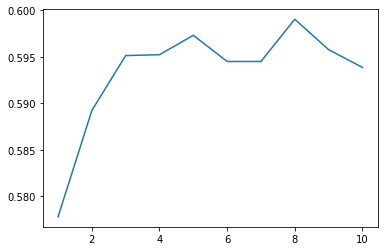

In [31]:
plt.plot(range(1, 11), scores)
plt.show

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [37]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [38]:
test_data = newsgroups['data']
test_target = newsgroups['target']

In [39]:
test_data = [text.lower() for text in test_data]
test_data = [re.sub('[^0-9a-zA-Z]+', ' ', text) for text in test_data]
new_test_data = []
new_test_target = np.empty((0, 1), int)
for i, text in enumerate(test_data):
    if text.isspace():
        continue
    if text == '':
        continue
    new_test_data.append(text)
    new_test_target = np.append(new_test_target, test_target[i])

In [40]:
test_matrix = vectorizer.transform(new_test_data)
tfidf_transformer = TfidfTransformer()
test_matrix = tfidf_transformer.fit_transform(test_matrix, new_test_target)
test_matrix = test_matrix.todense()
test_matrix = np.array(test_matrix)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [41]:
my_clf = MyKNeighborsClassifier(n_neighbors=(np.argmax(scores)+1),
                                algorithm='brute',
                                metric='cosine')
my_clf.fit(matrix, new_target)
test_score = my_clf.score(test_matrix, new_test_target)
print(test_score)

0.5290737446983171
